### Importing function and setting up dirs

In [1]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "/storage"
base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in os.listdir(base_dir + "/HCP_7T") if len(i) == 6]
base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in os.listdir(base_dir + "/HCP_3T") if len(i) == 6]

path_7t = {}
path_3t = {}



for i in base_dir_7t:
    path_7t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.05.nii.gz" ,"data" : i + "/T1w/Diffusion_7T/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion_7T/bvals" , "bvecs" : i + "/T1w/Diffusion_7T/bvecs"
                      , "brain_mask" : i + "/T1w/Diffusion_7T/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion_7T/grad_dev.nii.gz"}
for i in base_dir_3t:
    path_3t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.25.nii.gz" , "data" : i + "/T1w/Diffusion/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion/bvals" , "bvecs" : i + "/T1w/Diffusion/bvecs"
                       , "brain_mask" : i + "/T1w/Diffusion/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion/grad_dev.nii.gz"}
    
    
path = {'3T': path_3t, "7T": path_7t}
p = list(path_7t.keys())
q = list(path_3t.keys())
common = list(set(p) & set(q))
common.sort()
print("number of common Subjects ",len(common))

number of common Subjects  171


In [3]:
path_3t[common[0]]

{'3d_scan': '/storage/HCP_3T/100610/T1w/T1w_acpc_dc_restore_1.25.nii.gz',
 'data': '/storage/HCP_3T/100610/T1w/Diffusion/data.nii.gz',
 'bvals': '/storage/HCP_3T/100610/T1w/Diffusion/bvals',
 'bvecs': '/storage/HCP_3T/100610/T1w/Diffusion/bvecs',
 'brain_mask': '/storage/HCP_3T/100610/T1w/Diffusion/nodif_brain_mask.nii.gz',
 'grad_dev': '/storage/HCP_3T/100610/T1w/Diffusion/grad_dev.nii.gz'}

### Functions to read the files in nifty

In [5]:
def get_ids():
    return common

def load_hcp(id_load,res):
    
    load_from = path[res][id_load]
    
    data,affine = load_nifti(load_from["data"])
    
    mask,affine = load_nifti(load_from["brain_mask"])
    
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    
    gtab = gradient_table(bvals, bvecs)
    
    return data,mask,gtab

def load_gtab(id_load,res):
    load_from = path[res][id_load]
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    return gtab

### Referred from DeepDTI paper

In [244]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy.linalg import inv
from numpy.linalg import pinv
# from numpy.linalg import lstsq
from scipy.linalg import lstsq
from numpy.linalg import solve
from numpy import inf
import numpy as np

import torchio as tio
import SimpleITK as sitk
import skimage.metrics as sm


dsm = np.array([0.91, 0.416, 0,0, 0.91, 0.416,0.416, 0, 0.91,0.91, -0.416, 0,0, 0.91, -0.416,-0.416, 0, 0.91])
dsm = dsm.reshape(6,3)
dsm_norm = np.copy(dsm)
dsm_mag = np.sqrt(dsm[:,0]**2 + dsm[:,1]**2 + dsm[:,2]**2)
for i in range(3):
    dsm_norm[:,i] = dsm[:,i] / dsm_mag

def rot3d(arg):
    x,y,z = arg[0],arg[1],arg[2]
    Rx = np.array([[1 ,0 ,0 ],[0,np.cos(x),-np.sin(x)],[0 ,np.sin(x) ,np.cos(x)]])
    Ry = np.array([[np.cos(y),0 ,np.sin(y) ],[0,1,0],[-np.sin(y),0,np.cos(y)]])
    Rz = np.array([[np.cos(z) ,-np.sin(z) ,0 ],[np.sin(z),np.cos(z),0],[0 ,0,1]])
    R = Rx @ Ry @ Rz
    return R

def amatrix(mat):
    
    a = [mat[:,0] * mat[:,0],2 * mat[:,0] * mat[:,1], 2* mat[:,0] * mat[:,2],
        mat[:,1] * mat[:,1],2 * mat[:,1] * mat[:,2], mat[:,2] * mat[:,2]]
    return np.array(a).T

def optimal_dirs(gtab,num_iter,num_dirs,debug = False,base_bval = 5):
    rotang_all = []
    angerr_all  = []
    condnum_all = []
    ind_all = []
    dirs = np.array(gtab.bvecs[np.where(gtab.bvals != base_bval)[0]])
    for i in range(0,num_iter):
        
        d = np.random.rand(1,3) * 2 * np.pi
        rotang = d[0]
        R = rot3d(rotang)
        dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T
        
        ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
        minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)

        mean_ang_err = np.mean(np.amin(ang_error,1))
        condnum = np.linalg.cond(amatrix(dirs[idx]))
        
        idx.sort()
        if (mean_ang_err < 5 and condnum < 1.6):
            if ((len(ind_all) == 0 ) or  len(np.where((ind_all == idx).all(axis=1))[0]) == 0 ):
                angerr_all.append(mean_ang_err)
                condnum_all.append(condnum)
                ind_all.append(idx)
                rotang_all.append(rotang)
    condnum_all = np.array(condnum_all)
    indx  = condnum_all.argsort()[:num_dirs]
    if (debug):
        print("Lowest Condition Number : ",condnum_all[indx])
    ind_use = np.array(ind_all)[indx]
    condnum_use = condnum_all[condnum_all.argsort()[:5]]
    angerr_use = np.array(angerr_all)[indx]
    rotang_use = np.array(rotang_all)[indx]
    return ind_use,condnum_all[indx]




In [165]:
def norm(data,typ=None):
    if(typ=="ZNorm"):
        transform = tio.transforms.RescaleIntensity()
        return transform(data)
    return ((data-np.min(data))/(np.max(data)-np.min(data)))



def resampler(data,idx,b0,do_norm=True):
    resampled_img = []
    resampled_img.append(data[:,:,:,int(b0)])
    for i in idx:
        resampled_img.append(data[:,:,:,int(i)])
    data = np.stack(resampled_img, axis=3)
    data, mask = median_otsu(data, vol_idx=range(0, data.shape[-1]),autocrop=True, dilate=2)
    if(do_norm):
        data = norm(data,typ="ZNorm")
    return data,mask

In [7]:
limited_common = common[:40]

In [8]:
len(limited_common)

40

In [19]:
limited_common

['100610',
 '102311',
 '102816',
 '104416',
 '105923',
 '108323',
 '109123',
 '111312',
 '111514',
 '114823',
 '115017',
 '115825',
 '116726',
 '118225',
 '125525',
 '126426',
 '128935',
 '130114',
 '130518',
 '131722',
 '132118',
 '134627',
 '134829',
 '135124',
 '137128',
 '140117',
 '144226',
 '145834',
 '146129',
 '146432',
 '146735',
 '146937',
 '148133',
 '155938',
 '156334',
 '157336',
 '158035',
 '158136',
 '159239',
 '162935']

### Normalization 

In [151]:
curr_id = '100610'

In [152]:
data,mask,gtab = load_hcp(curr_id,'3T')

In [153]:
data_7t,mask_7t,gtab_7t = load_hcp(curr_id,'7T')

In [154]:
data.shape,data_7t.shape

((145, 174, 145, 288), (173, 207, 173, 143))

In [27]:
gtab = load_gtab(curr_id,'3T')

data,mask,gtab = load_hcp(curr_id,'3T')

idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))

idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]


/tmp/ipykernel_256863/843249465.py:54: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


Lowest Condition Number :  [1.41846062 1.42238217 1.42797114 1.45020355 1.45105456]


In [155]:
idx[0],curr_id

(array([141, 167, 177, 183, 231, 258]), '100610')

In [156]:
j=0
sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
## picking one base bval volume randomly from the data
sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]

## picking the bvals,bvecs and corresponding vols from the data 
bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)

In [159]:
data6,mask6 = resampler(data,idx[j],sample,do_norm=False)

In [ ]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram((data * np.expand_dims(mask,3)),bins=10)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()


## Masking

Text(0.5, 1.0, 'modified')

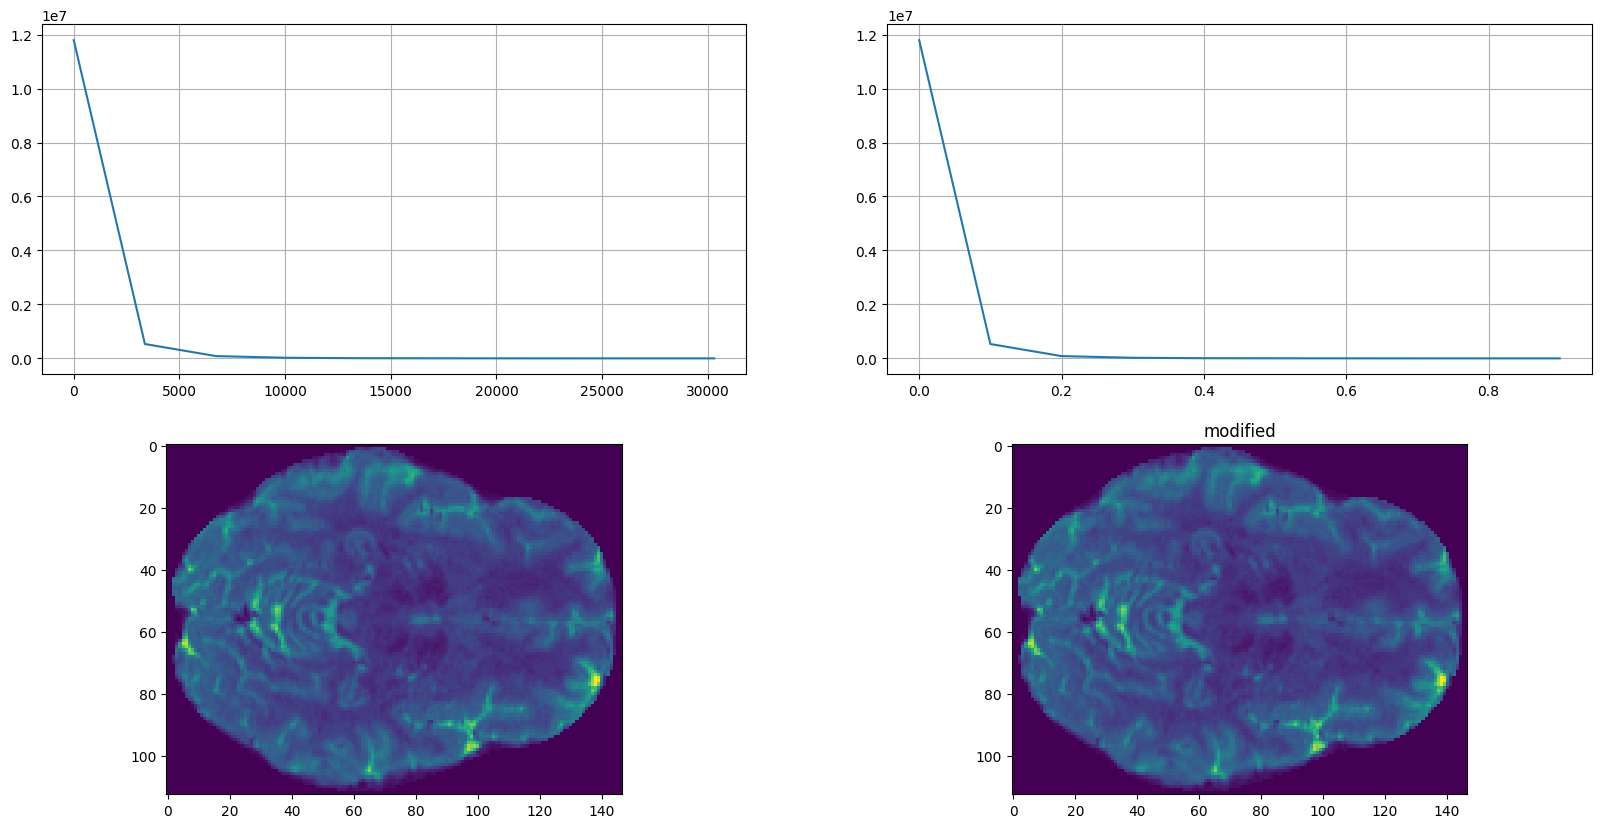

In [346]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
transform = tio.transforms.RescaleIntensity()
data6_mask = data6 * np.expand_dims(mask6,3)
data6_norm = transform(data6_mask)
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=10)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])
axis[1][1].set_title("modified")

In [347]:
hist,bins

({'hr6': array([11793673,   531537,    83989,    22004,     6185,     2620,
             1154,      412,       58,        7]),
  'hr6_norm': array([11793673,   531537,    83989,    22004,     6185,     2620,
             1154,      412,       58,        7])},
 {'hr6': array([    0.    ,  3367.4766,  6734.953 , 10102.43  , 13469.906 ,
         16837.383 , 20204.86  , 23572.336 , 26939.812 , 30307.29  ,
         33674.766 ], dtype=float32),
  'hr6_norm': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
        dtype=float32)})

## ZNormalization

Text(0.5, 1.0, 'modified')

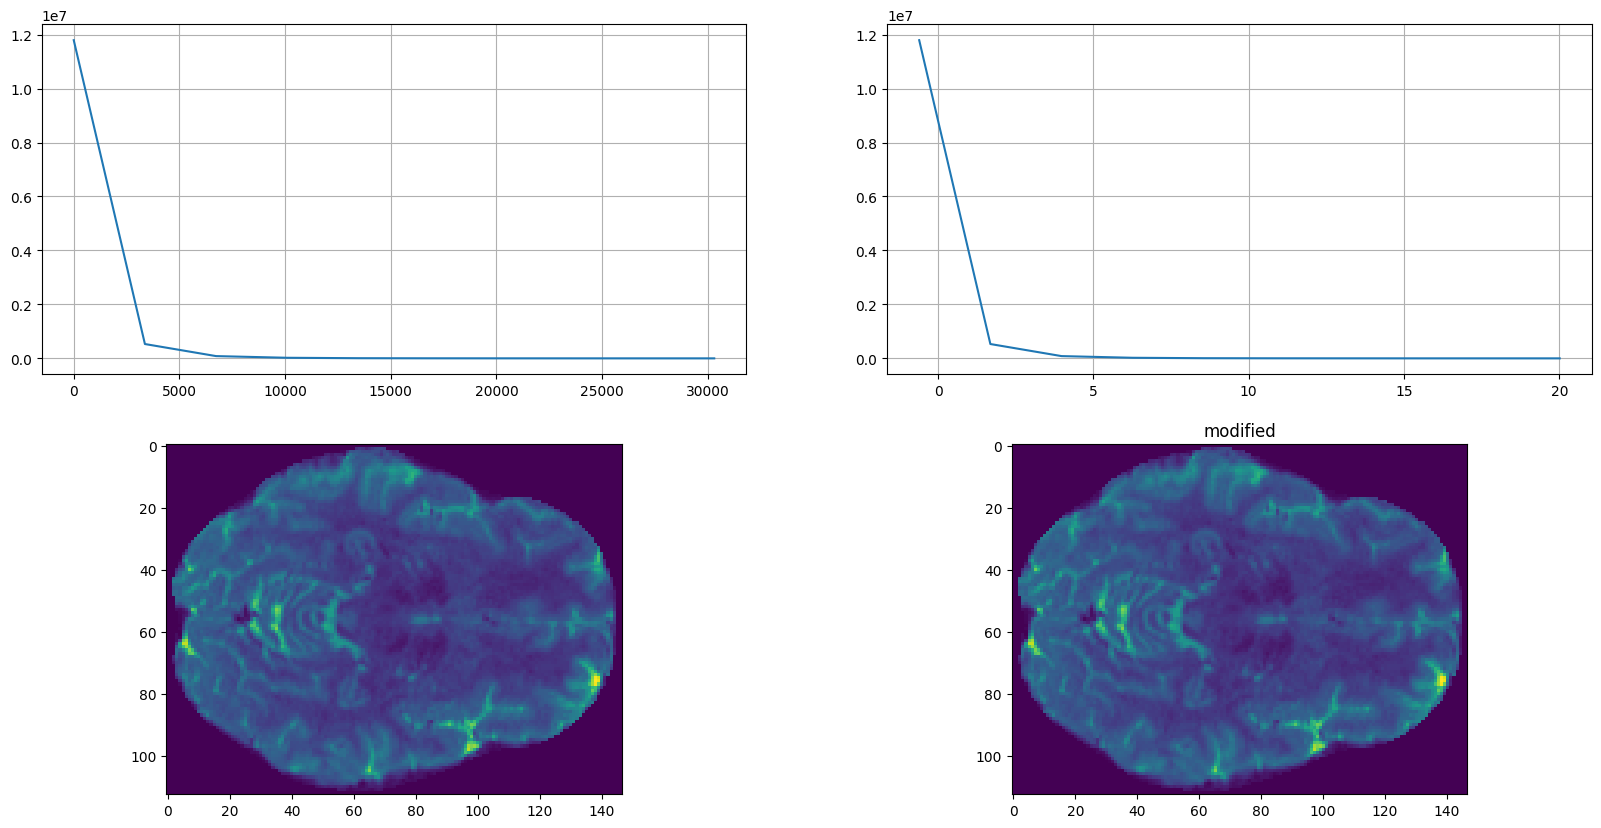

In [309]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
transform = tio.transforms.ZNormalization()
data6_norm = transform(data6)
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=10)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])
axis[1][1].set_title("modified")

In [310]:
hist,bins

({'hr6': array([11793673,   531537,    83989,    22004,     6185,     2620,
             1154,      412,       58,        7]),
  'hr6_norm': array([11793673,   531537,    83989,    22004,     6185,     2620,
             1154,      412,       58,        7])},
 {'hr6': array([    0.    ,  3367.4766,  6734.953 , 10102.43  , 13469.906 ,
         16837.383 , 20204.86  , 23572.336 , 26939.812 , 30307.29  ,
         33674.766 ], dtype=float32),
  'hr6_norm': array([-0.6051377,  1.6857373,  3.976612 ,  6.267487 ,  8.558362 ,
         10.849237 , 13.140112 , 15.430987 , 17.721863 , 20.012737 ,
         22.303612 ], dtype=float32)})

Text(0.5, 1.0, 'modified')

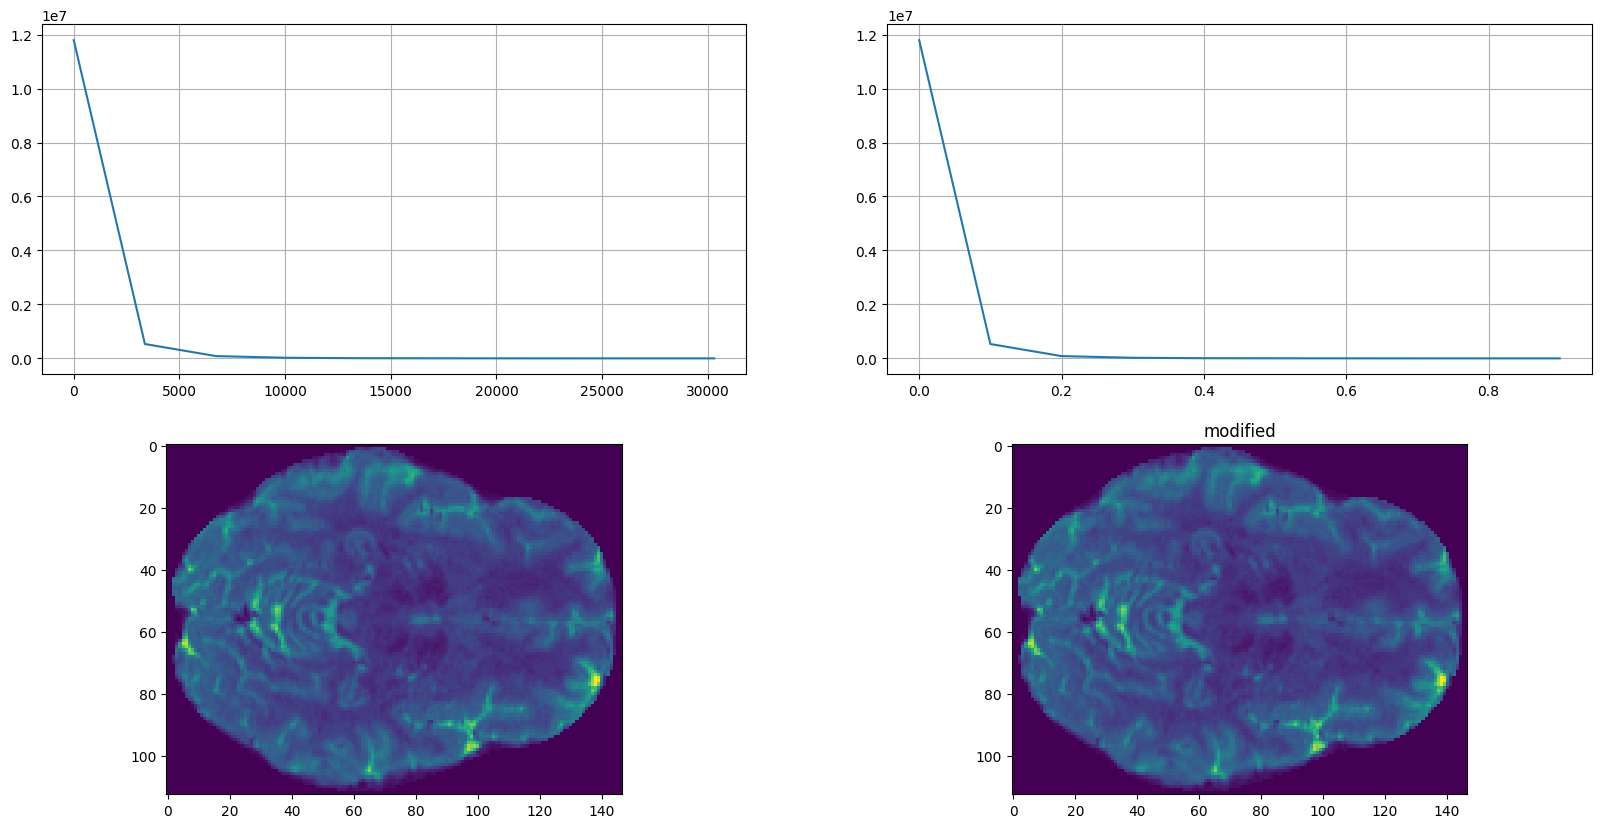

In [304]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
transform = tio.transforms.ZNormalization()
temp = tio.transforms.RescaleIntensity()
data6_norm = temp(transform(data6))
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=10)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6_norm[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])
axis[1][1].set_title("modified")

In [305]:
hist,bins

({'hr6': array([11793673,   531537,    83989,    22004,     6185,     2620,
             1154,      412,       58,        7]),
  'hr6_norm': array([11793673,   531537,    83989,    22004,     6185,     2620,
             1154,      412,       58,        7])},
 {'hr6': array([    0.    ,  3367.4766,  6734.953 , 10102.43  , 13469.906 ,
         16837.383 , 20204.86  , 23572.336 , 26939.812 , 30307.29  ,
         33674.766 ], dtype=float32),
  'hr6_norm': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
        dtype=float32)})

## Rescale Intensity 

Text(0.5, 1.0, 'modified')

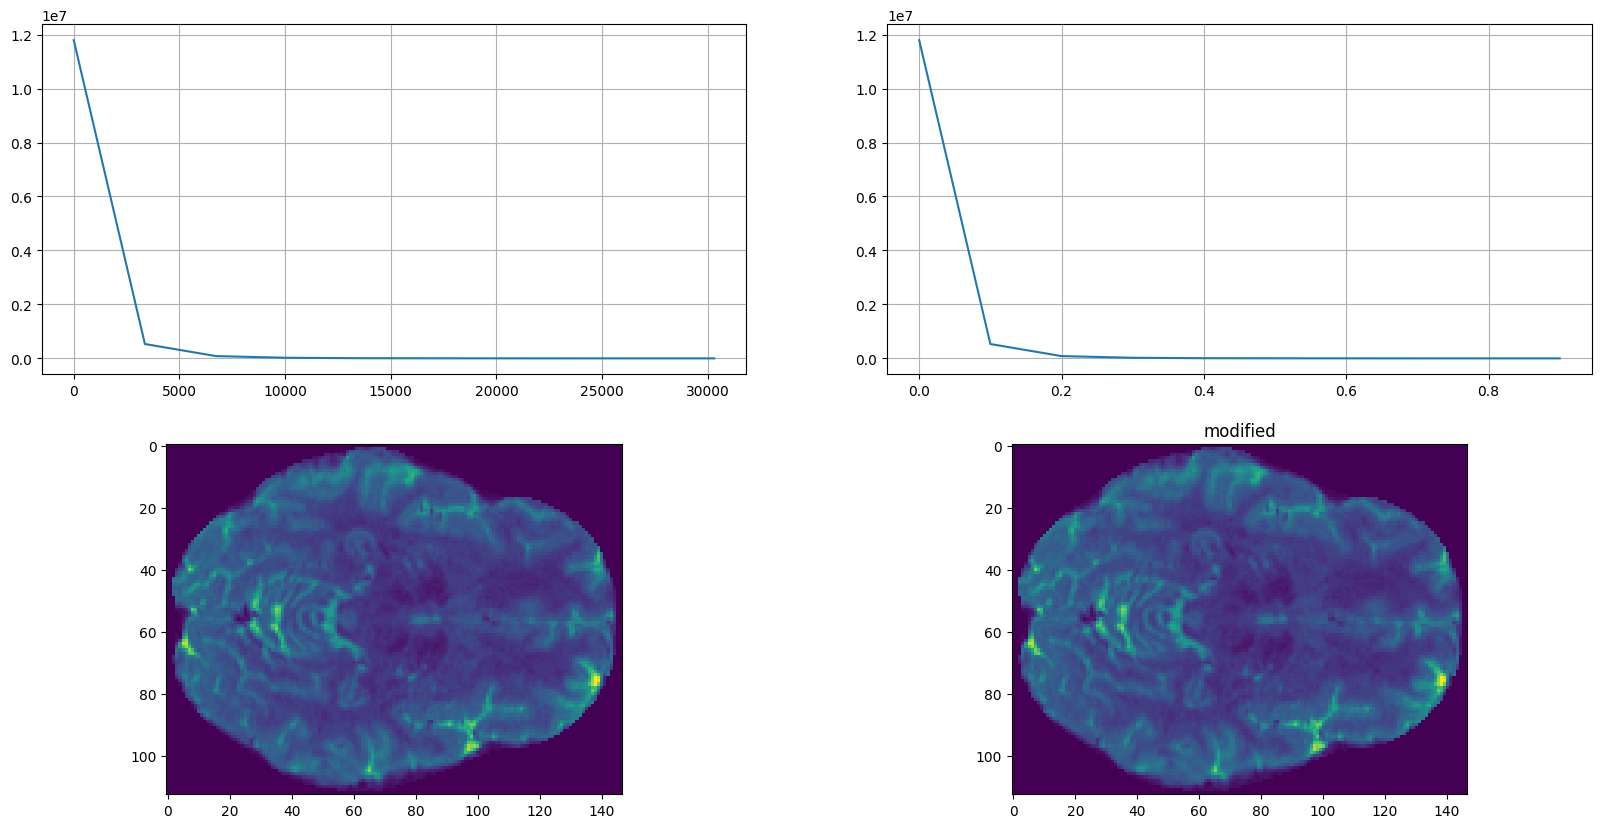

In [311]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
transform = tio.transforms.RescaleIntensity()

data6_norm = transform(data6)
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=10)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6_norm[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])
axis[1][1].set_title("modified")

# Rescale Intensity

Text(0.5, 1.0, 'modified')

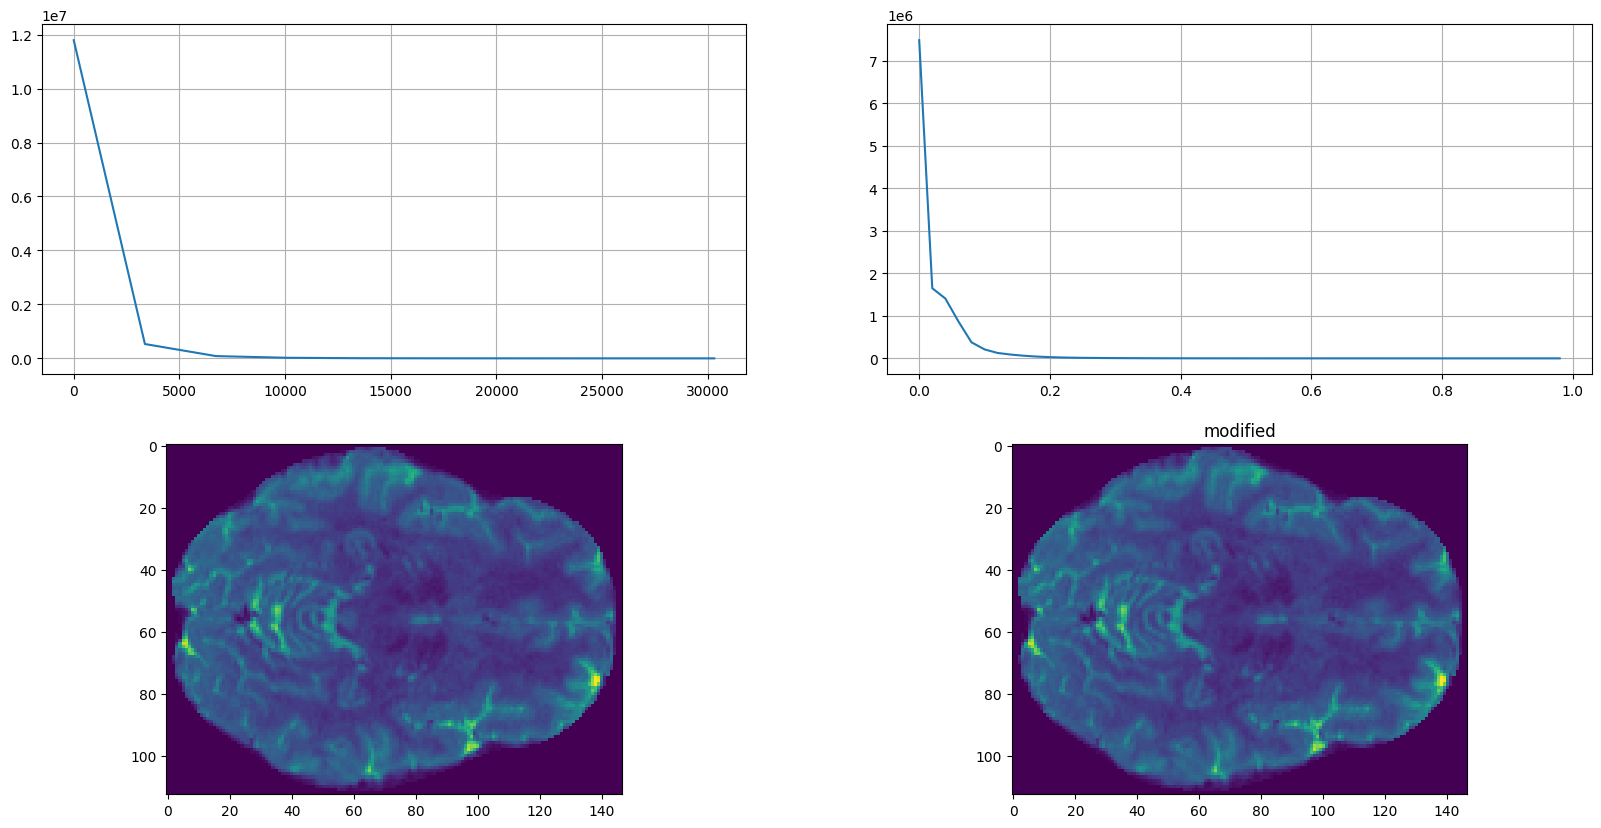

In [349]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
transform = tio.transforms.RescaleIntensity(masking_method=lambda x: x > 0)

data6_norm = transform(data6)
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=50)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])

axis[1][1].set_title("modified")

In [318]:
def mask_fn(data):
    return data['mask']

In [ ]:
data_mod['data']
transform = tio.transforms.RescaleIntensity()
data6_norm = transform(data6)

In [ ]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=50)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])

axis[1][1].set_title("modified")

In [332]:
m = mask

In [333]:
m.shape

(145, 174, 145)

In [334]:
bins['hr6_norm'],hist['hr6_norm']


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 array([7486862, 1650279, 1408637,  869694,  378201,  210572,  127095,
          89624,   62078,   42168,   28900,   20291,   14818,   11303,
           8677,    6835,    5337,    4107,    3202,    2523,    1956,
           1470,    1124,     919,     716,     690,     570,     511,
            425,     424,     333,     255,     232,     180,     154,
            128,      98,      71,      70,      45,      26,      11,
              9,       7,       5,       4,       2,       0,       0,
              1]))

In [298]:
bins['hr6_norm'],hist['hr6_norm']


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 array([6618055,  183227,  318312,  404670,  436651,  428721,  415191,
         400423,  381375, 2855014]))

In [294]:
bins['hr6_norm'],hist['hr6_norm']


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 array([11793673,   531537,    83989,    22004,     6185,     2620,
            1154,      412,       58,        7]))

In [386]:
psnr = []
for i in np.arange(0,0.2,0.01):
    transform = tio.transforms.RescaleIntensity(percentiles=(i,100),masking_method=lambda x: x > 0)
    data6_norm = transform(data6)
    psnr.append(sm.peak_signal_noise_ratio(norm(data6),data6_norm))

In [387]:
len(psnr)

20

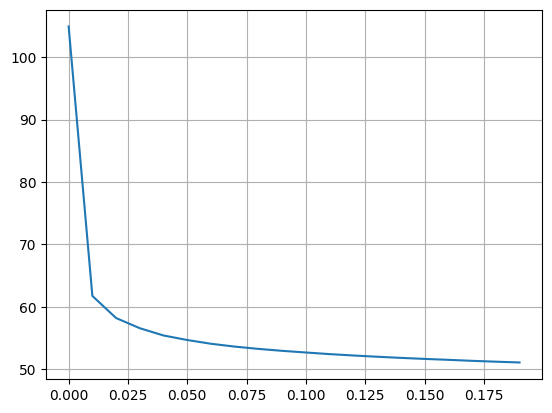

In [388]:
to_show = np.arange(0,0.2,0.01)
plt.plot(to_show,psnr[:len(to_show)])
plt.grid()

In [317]:
bins['hr6_norm'],hist['hr6_norm']


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 array([7486862, 1650279, 1408637,  869694,  378201,  210572,  127095,
          89624,   62078,   42168,   28900,   20291,   14818,   11303,
           8677,    6835,    5337,    4107,    3202,    2523,    1956,
           1470,    1124,     919,     716,     690,     570,     511,
            425,     424,     333,     255,     232,     180,     154,
            128,      98,      71,      70,      45,      26,      11,
              9,       7,       5,       4,       2,       0,       0,
              1]))

In [ ]:
f, axis = plt.subplots(2, 2)
f.set_figwidth(20)
f.set_figheight(10)

i=40
transform = tio.transforms.RescaleIntensity()
temp = tio.transforms.Clamp(out_min=0.0001,out_max=1)

data6_norm = temp(transform(data6))
hist,bins = {},{}
hist['hr6'],bins['hr6'] = np.histogram(data6)
hist['hr6_norm'],bins['hr6_norm'] = np.histogram(data6_norm,bins=10)

axis[0][0].plot(bins['hr6'][:-1], hist['hr6'],label="base")
axis[1][0].imshow(data6_norm[:,:,i,0])
axis[0][0].grid()

axis[0][1].plot(bins['hr6_norm'][:-1], hist['hr6_norm'],label="norm")
axis[0][1].grid()
axis[1][1].imshow(data6_norm[:,:,i,0])

axis[1][1].set_title("modified")